Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [15]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 28, 28) (100000,)
Validation set (5000, 28, 28) (5000,)
Test set (5000, 28, 28) (5000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 784) (100000, 10)
Validation set (5000, 784) (5000, 10)
Test set (5000, 784) (5000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [8]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    #Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    #Computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    prbs = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
    loss = tf.reduce_mean(prbs + beta*tf.nn.l2_loss(weights))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    

In [19]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 10e-4}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.400478
Minibatch accuracy: 15.6%
Validation accuracy: 15.2%
Minibatch loss at step 500: 2.794219
Minibatch accuracy: 75.8%
Validation accuracy: 76.8%
Minibatch loss at step 1000: 1.374625
Minibatch accuracy: 85.2%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 1.594421
Minibatch accuracy: 76.6%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 1.064646
Minibatch accuracy: 76.6%
Validation accuracy: 80.6%
Minibatch loss at step 2500: 1.002532
Minibatch accuracy: 79.7%
Validation accuracy: 81.9%
Minibatch loss at step 3000: 0.761428
Minibatch accuracy: 85.9%
Validation accuracy: 82.2%
Test accuracy: 87.9%


In [13]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

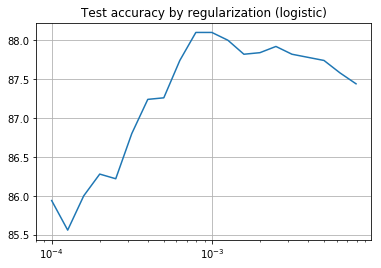

In [16]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Now we add the regularization to the neural net with ReLU hidden layer.

In [22]:
batch_size = 128
num_nodes = 1024

graph2 = tf.Graph()
with graph2.as_default():
    
    #Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    #Computation
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden_layer1, weights2) + biases2
    prbs = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
    loss = tf.reduce_mean(prbs + beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [23]:
num_steps = 3001

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 598.062317
Minibatch accuracy: 10.2%
Validation accuracy: 26.3%
Minibatch loss at step 500: 191.131378
Minibatch accuracy: 83.6%
Validation accuracy: 82.2%
Minibatch loss at step 1000: 114.305740
Minibatch accuracy: 90.6%
Validation accuracy: 82.4%
Minibatch loss at step 1500: 69.577576
Minibatch accuracy: 77.3%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 41.701920
Minibatch accuracy: 86.7%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.488457
Minibatch accuracy: 83.6%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 15.424375
Minibatch accuracy: 92.2%
Validation accuracy: 88.1%
Test accuracy: 92.7%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [27]:
batch_size = 128
num_nodes = 1024

graph2 = tf.Graph()
with graph2.as_default():
    
    #Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    #Computation
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden_layer1, weights2) + biases2
    prbs = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
    loss = tf.reduce_mean(prbs + beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [28]:
num_steps = 3001
num_batches = 5

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 708.006836
Minibatch accuracy: 14.8%
Validation accuracy: 27.7%
Minibatch loss at step 500: 191.266937
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 115.994736
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 1500: 70.345703
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2000: 42.661934
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2500: 25.873693
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3000: 15.693985
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Test accuracy: 82.5%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [29]:
batch_size = 128
num_nodes = 1024

graph2 = tf.Graph()
with graph2.as_default():
    
    #Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    #Computation
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop = tf.nn.dropout(hidden_layer1, 0.5)
    logits = tf.matmul(drop, weights2) + biases2
    prbs = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
    loss = tf.reduce_mean(prbs + beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [30]:
num_steps = 3001
num_batches = 5

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 770.085083
Minibatch accuracy: 12.5%
Validation accuracy: 32.2%
Minibatch loss at step 500: 191.822922
Minibatch accuracy: 100.0%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 116.406342
Minibatch accuracy: 100.0%
Validation accuracy: 78.5%
Minibatch loss at step 1500: 70.615097
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Minibatch loss at step 2000: 42.903442
Minibatch accuracy: 99.2%
Validation accuracy: 78.6%
Minibatch loss at step 2500: 25.979364
Minibatch accuracy: 100.0%
Validation accuracy: 78.8%
Minibatch loss at step 3000: 15.756669
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Test accuracy: 86.5%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [86]:
batch_size = 256
num_nodes1 = 1024
num_nodes2 = 512
num_nodes3 = 60

graph3 = tf.Graph()
with graph3.as_default():
    
    #Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes1],stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes1, num_nodes2],stddev=np.sqrt(2.0 /num_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_nodes2, num_nodes3],stddev=np.sqrt(2.0 /num_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_nodes3, num_labels],stddev=np.sqrt(2.0 /num_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    global_step = tf.Variable(0)
    beta = tf.placeholder(tf.float32)
    
    #Computation
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(hidden_layer1, 0.5)
    hidden_layer2 = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(hidden_layer2, 0.5)
    hidden_layer3 = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(hidden_layer3, 0.5)
    logits = tf.matmul(drop3, weights4) + biases4
    prbs = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
    loss = tf.reduce_mean(prbs) #+ beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)))
    
    #Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.9)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #Predictions
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, weights2) + biases2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(layer3_valid, weights4) + biases4)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(layer3_test, weights4) + biases4)
    

In [87]:
num_steps = 15001

with tf.Session(graph=graph3) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}#, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.673212
Minibatch accuracy: 9.8%
Validation accuracy: 26.5%
Minibatch loss at step 500: 0.642299
Minibatch accuracy: 81.6%
Validation accuracy: 86.0%
Minibatch loss at step 1000: 0.468276
Minibatch accuracy: 82.4%
Validation accuracy: 87.2%
Minibatch loss at step 1500: 0.495179
Minibatch accuracy: 85.2%
Validation accuracy: 87.8%
Minibatch loss at step 2000: 0.336768
Minibatch accuracy: 90.2%
Validation accuracy: 88.4%
Minibatch loss at step 2500: 0.417498
Minibatch accuracy: 88.7%
Validation accuracy: 89.1%
Minibatch loss at step 3000: 0.464351
Minibatch accuracy: 86.7%
Validation accuracy: 88.9%
Minibatch loss at step 3500: 0.421913
Minibatch accuracy: 86.3%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.445144
Minibatch accuracy: 85.2%
Validation accuracy: 89.5%
Minibatch loss at step 4500: 0.279720
Minibatch accuracy: 92.2%
Validation accuracy: 89.8%
Minibatch loss at step 5000: 0.389723
Minibatch accuracy: 87.1%
Validation accuracy

The test accuracy is __95.2__ percent! This is amazing!